In [1]:
def airmass(C):
    plot_title = 'GOES-16 RGB Air Mass'
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C08'].data - C['CMI_C10'].data
    G = C['CMI_C12'].data - C['CMI_C13'].data
    B = C['CMI_C08'].data-273.15 # remember to convert to Celsius

    # Normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
    R = (R--26.2)/(0.6--26.2)
    G = (G--42.2)/(6.7--42.2)
    B = (B--64.65)/(-29.25--64.65)

    # Invert B
    B = 1-B

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])
    return R, RGB, plot_title

    
def water_vapor(C):
    plot_title = 'GOES-16 RGB Water Vapor'
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C13'].data-273.15 # remember to invert and convert to Celsius
    G = C['CMI_C08'].data-273.15 # remember to invert and convert to Celsius
    B = C['CMI_C10'].data-273.15 # remember to invert and convert to Celsius

    # Normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
    R = (R--70.86)/(5.81--70.86)
    G = (G--58.49)/(-30.48--58.49)
    B = (B--28.03)/(-12.12--28.03)

    # Invert the colors
    R = 1-R
    G = 1-G
    B = 1-B

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])
    return R, RGB, plot_title

def day_cloud_phase(C):
    plot_title = 'GOES-16 RGB Day Cloud Phase'
    # Load the three channels into appropriate R, G, and B variables
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C13'].data-273.15 # convert from Kelvin to Celsius
    G = C['CMI_C02'].data
    B = C['CMI_C05'].data

    # Normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
    R = 1-(R--53.5)/(7.5--53.5)
    G = (G-0)/(.78-0)
    B = (B-.01)/(0.59--0.01)

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])
    return R, RGB, plot_title

def true_color(C):
    plot_title = 'GOES-16 RGB True Color'
    # Load the three channels into appropriate R, G, and B variables
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)


    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([R, G, B])

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])

    return R, RGB, plot_title

In [2]:
def scan_time(C):
    # Scan's start time, converted to datetime object
    scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

    # Scan's end time, converted to datetime object
    scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

    # File creation time, convert to datetime object
    file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

    # The 't' variable is the scan's midpoint time
    # I'm not a fan of numpy datetime, so I convert it to a regular datetime object
    midpoint = str(C['t'].data)[:-8]
    scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

    #print('Scan Start    : %s' % scan_start)
    #print('Scan midpoint : %s' % scan_mid)
    #print('Scan End      : %s' % scan_end)
    #print('File Created  : %s' % file_created)
    #print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))
    return scan_start

In [3]:
def reproj_meshgrid(C):
    # Satellite height
    sat_h = C['goes_imager_projection'].perspective_point_height

    # Satellite longitude
    sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

    # Satellite sweep
    sat_sweep = C['goes_imager_projection'].sweep_angle_axis

    # The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
    # See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
    x = C['x'][:] * sat_h
    y = C['y'][:] * sat_h

    # Create a pyproj geostationary map object
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

    # Perform cartographic transformation. That is, convert image projection coordinates (x and y)
    # to latitude and longitude values.
    XX, YY = np.meshgrid(x, y)
    lons, lats = p(XX, YY, inverse=True)

    return lats,lons

def plot_sat(l, stretch):
    # Draw zoomed map
    mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-stretch, llcrnrlat=l['latitude']-stretch,\
             urcrnrlon=l['longitude']+stretch, urcrnrlat=l['latitude']+stretch,)

    # Now we can plot the GOES data on a zoomed in map centered over Utah.
    plt.figure(figsize=[8, 8])

    newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
    newmap.set_array(None)

    mZ.drawcoastlines(linewidth=.25)
    mZ.drawcountries(linewidth=.25)
    mZ.drawstates(linewidth=.25)

    plt.title(plot_title, loc='left', fontweight='semibold', fontsize=15);
    #plt.title('GOES-16 Water Vapor', loc='left', fontweight='semibold', fontsize=15);
    plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

In [4]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [5]:
#FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20182831437203_e20182831439576_c20182831440087.nc'
FILE = 'C:/data/satellite/OR_ABI-L2-MCMIPC-M6_G16_s20191260006258_e20191260009031_c20191260009141.nc'
C = xarray.open_dataset(FILE)

In [7]:
scan_start = scan_time(C)
#R, RGB, plot_title = airmass(C)
R, RGB, plot_title = day_cloud_phase(C)
lats,lons = reproj_meshgrid(C)
# Create a color tuple for pcolormesh

# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the strange nature of pcolormesh.
rgb = RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to Stack Overflow. Not sure why.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)
# Assign the pixels showing space as a single point in the Gulf of Alaska

C:\Users\tjtur\Anaconda3\lib\site-packages\matplotlib\colors.py:259: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
C:\Users\tjtur\Anaconda3\lib\site-packages\matplotlib\colors.py:259: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


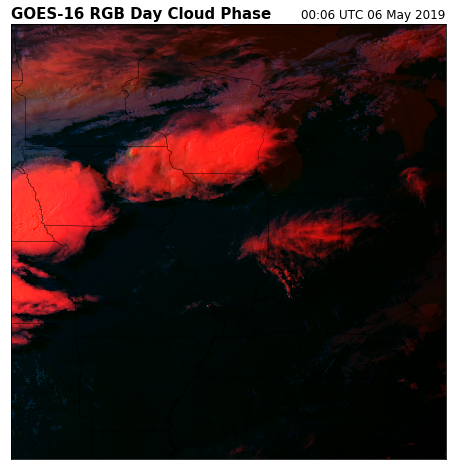

In [8]:
lats[np.isnan(R)] = 57
lons[np.isnan(R)] = -152

l = {'latitude': 40.0, 'longitude': -89.0}
stretch = 8.0
plot_sat(l,stretch)